# Обучение определения фейковых фактов о COVID и вакцинации

In [53]:
import math

import torch
import pandas as pd
import numpy as np

In [54]:
DEVICE = 'cpu'
if torch.backends.mps.is_available():
    DEVICE = 'mps'
if torch.cuda.is_available():
    DEVICE = 'cuda'

In [55]:
from pathlib import Path

DATA_PATH = Path('data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

DATA_CACHE = Path('data/cache_dir/')
DATA_CACHE.mkdir(parents=True, exist_ok=True)

DATA_PATH_SAVE_MODELS = Path('data/models/')
DATA_PATH_SAVE_MODELS.mkdir(parents=True, exist_ok=True)

pd.set_option('display.max_colwidth', 500) 

In [56]:
MODEL_NAME = "roberta-base"
TRAIN_DF_NAME = "covid_vaccine_fake_clear.xlsx"
MAX_LENGTH = 128
BATCH_SIZE = 128

# Датасет

In [57]:
data_df = pd.read_excel(DATA_PATH / TRAIN_DF_NAME)
data_df.head(1)

,text,label_idx,original_label_1,source,original_label_2,label_str
0,The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.,0,real,nanyy1025,NaN,Real


## Важно, урезаем комментарии если это нужно

In [58]:
import pandas as pd

def balance_label_idx(data_df: pd.DataFrame, target_label: int = 2, target_count: int = 30000, random_state: int = 42) -> pd.DataFrame:
    """
    Оставляет все категории label_idx, но уменьшает количество target_label до target_count случайным образом.
    Всегда сохраняет строки, где source == 'handle_marked'.
    
    :param data_df: Исходный DataFrame.
    :param target_label: Значение label_idx, которое нужно уменьшить (по умолчанию 2).
    :param target_count: Количество строк, которое нужно оставить для target_label (по умолчанию 30 000).
    :param random_state: Фиксированный seed для воспроизводимости выборки.
    :return: Обновленный DataFrame.
    """
    # Отдельно выделяем строки, где source == 'handle_marked' (их не балансируем)
    df_handle_marked = data_df[data_df["source"] == "handle_marked"]
    
    # Исключаем эти строки из дальнейшей обработки
    data_df = data_df[data_df["source"] != "handle_marked"]

    # Оставляем все строки, кроме тех, у которых label_idx == target_label
    df_other_labels = data_df[data_df["label_idx"] != target_label]
    
    # Выбираем случайные target_count строк, где label_idx == target_label
    df_target_label = data_df[data_df["label_idx"] == target_label].sample(
        n=min(target_count, len(data_df[data_df["label_idx"] == target_label])), 
        random_state=random_state
    )
    
    # Объединяем обратно и добавляем строки с source == 'handle_marked'
    balanced_df = pd.concat([df_other_labels, df_target_label, df_handle_marked])

    # Перемешиваем строки и сбрасываем индексы
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return balanced_df

data_df = balance_label_idx(data_df, target_count=100000)

In [59]:
data_df = data_df.fillna("")

for col in data_df.select_dtypes(include=["object", "bool"]).columns:
    data_df[col] = data_df[col].astype(str)

In [60]:
idx2label = {
    0: "Real",
    1: "Fake",
    2: "Comments"
}

In [61]:
NUM_CLASSES = len(idx2label)
NUM_CLASSES

3

In [62]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df["label_idx"], random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_val_df, test_size=0.1, stratify=train_val_df["label_idx"], random_state=42, shuffle=True)

print(f"Размер тренировочного набора: {len(train_df)}")
print(f"Размер валидационного набора: {len(val_df)}")
print(f"Размер тестового набора: {len(test_df)}")

Размер тренировочного набора: 94179
Размер валидационного набора: 10465
Размер тестового набора: 11628


In [63]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PreTrainedTokenizer
import pandas as pd
from typing import Dict, Tuple


class TokenizedDataset(Dataset):
    def __init__(
        self, 
        dataframe: pd.DataFrame, 
        tokenizer: PreTrainedTokenizer, 
        max_length: int, 
        tensor_dtype: Tuple[torch.dtype, torch.dtype, torch.dtype] = (torch.long, torch.long, torch.long)
    ):
        """
        Инициализация датасета с токенизацией.

        Args:
            dataframe (pd.DataFrame): DataFrame с колонками "text" и "label".
            tokenizer (PreTrainedTokenizer): Токенайзер для преобразования текста.
            max_length (int): Максимальная длина токенов.
            tensor_dtype (tuple): Типы данных для токенов и меток.
        """
        self.tensor_dtype = tensor_dtype

        # Токенизация данных
        tokenized_data = tokenizer(
            dataframe["text"].tolist(),
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        self.input_ids = tokenized_data["input_ids"].to(dtype=self.tensor_dtype[0])
        self.attention_mask = tokenized_data["attention_mask"].to(dtype=self.tensor_dtype[1])
        self.labels = torch.tensor(dataframe["label_idx"].tolist(), dtype=self.tensor_dtype[2])

    def __len__(self) -> int:
        """
        Возвращает количество примеров в датасете.
        """
        return len(self.labels)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Возвращает токенизированные данные и метки.

        Args:
            idx (int): Индекс примера.

        Returns:
            Dict[str, torch.Tensor]: Словарь с токенами и меткой.
        """
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx],
        }


In [64]:
from torch.utils.data import DataLoader
from transformers import PreTrainedTokenizer
import pandas as pd


def create_dataloader(
    dataframe: pd.DataFrame,
    tokenizer: PreTrainedTokenizer,
    max_length: int = 64,
    batch_size: int = 16,
    shuffle: bool = True,
    tensor_dtype=(torch.long, torch.long, torch.long),
) -> DataLoader:
    """
    Создание DataLoader из DataFrame.

    Args:
        dataframe (pd.DataFrame): DataFrame с колонками "text" и "label".
        tokenizer (PreTrainedTokenizer): Токенайзер для преобразования текста.
        max_length (int): Максимальная длина токенов.
        batch_size (int): Размер батча.
        shuffle (bool): Перемешивать ли данные.
        tensor_dtype (tuple): Типы данных для токенов и меток.

    Returns:
        DataLoader: DataLoader для работы с моделью.
    """
    dataset = TokenizedDataset(dataframe, tokenizer, max_length, tensor_dtype=tensor_dtype)
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
    )
    return dataloader


In [65]:
from transformers import RobertaTokenizer

tokenizer: RobertaTokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, cache_dir=DATA_CACHE)

train_loader = create_dataloader(
    dataframe=train_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = create_dataloader(
    dataframe=val_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = create_dataloader(
    dataframe=test_df,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Выводим размер набора данных
print(f"Размер тренировочного набора: {len(train_loader.dataset)}")
print(f"Размер валидационного набора: {len(val_loader.dataset)}")
print(f"Размер тестового набора: {len(test_loader.dataset)}")


Размер тренировочного набора: 94179
Размер валидационного набора: 10465
Размер тестового набора: 11628


# Модель

In [66]:
from typing import Tuple, Dict, Any

import torch
from torch.utils.data import DataLoader
from torch.optim import Optimizer
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score


class VaccineFakeClassifierTrainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: Optimizer,
        criterion: torch.nn.Module,
        device: torch.device,
    ):
        """
        Инициализация класса Trainer.

        Args:
            model: Модель для обучения (e.g., RobertaForSequenceClassification).
            train_loader: DataLoader для обучающего набора.
            val_loader: DataLoader для валидационного набора.
            optimizer: Оптимизатор.
            criterion: Функция потерь.
            device: Устройство ('cuda' или 'cpu').
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_metrics": [],
            "val_metrics": []
        }

        self.model.to(self.device)

    def train_epoch(self) -> Tuple[float, Dict[str, float]]:
        """
        Обучение модели за одну эпоху.

        Returns:
            Средние потери и метрики за эпоху.
        """
        self.model.train()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        for batch in tqdm(self.train_loader, desc="Training"):
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            running_loss += loss.item()

            loss.backward()
            self.optimizer.step()

            preds = logits.argmax(dim=-1)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        metrics = self._compute_metrics(all_preds, all_labels)

        epoch_loss = running_loss / len(self.train_loader)
        return epoch_loss, metrics

    def validate_epoch(self) -> Tuple[float, Dict[str, float]]:
        """
        Валидация модели за одну эпоху.

        Returns:
            Средние потери и метрики за эпоху.
        """
        self.model.eval()
        running_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                running_loss += loss.item()

                preds = logits.argmax(dim=-1)
                all_labels.append(labels.cpu())
                all_preds.append(preds.cpu())

        all_labels = torch.cat(all_labels)
        all_preds = torch.cat(all_preds)
        metrics = self._compute_metrics(all_preds, all_labels)

        epoch_loss = running_loss / len(self.val_loader)
        return epoch_loss, metrics

    def fit(self, num_epochs: int):
        """
        Обучение и валидация модели.

        Args:
            num_epochs: Общее количество эпох.
        """
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            train_loss, train_metrics = self.train_epoch()
            val_loss, val_metrics = self.validate_epoch()

            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_metrics"].append(train_metrics)
            self.history["val_metrics"].append(val_metrics)

            print(f"Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
            print(f"Train Metrics: {train_metrics} | Validation Metrics: {val_metrics}")

    def plot_results(self, metrics_to_plot=None):
        """
        Построение графиков потерь и метрик для обучения и валидации.

        Args:
            metrics_to_plot: Список метрик для визуализации.
        """
        if metrics_to_plot is None:
            metrics_to_plot = ["accuracy", "f1"]

        num_plots = len(metrics_to_plot) + 1
        plt.figure(figsize=(15, 5 * (num_plots // 2 + 1)))

        # График потерь
        plt.subplot((num_plots + 1) // 2, 2, 1)
        plt.plot(self.history["train_loss"], label="Train Loss", color="blue", linestyle="--")
        plt.plot(self.history["val_loss"], label="Validation Loss", color="red", linestyle="-")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss over Epochs")
        plt.legend()
        plt.grid(True)

        # Графики метрик
        for i, metric in enumerate(metrics_to_plot, start=2):
            train_metric = [m[metric] for m in self.history["train_metrics"]]
            val_metric = [m[metric] for m in self.history["val_metrics"]]

            plt.subplot((num_plots + 1) // 2, 2, i)
            plt.plot(train_metric, label=f"Train {metric.capitalize()}", color="blue", linestyle="--")
            plt.plot(val_metric, label=f"Validation {metric.capitalize()}", color="red", linestyle="-")
            plt.xlabel("Epochs")
            plt.ylabel(metric.capitalize())
            plt.title(f"{metric.capitalize()} over Epochs")
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def _compute_metrics(preds: torch.Tensor, labels: torch.Tensor) -> Dict[str, float]:
        """
        Вычисление метрик.

        Args:
            preds: Предсказания модели.
            labels: Истинные метки.

        Returns:
            Словарь метрик.
        """
        preds = preds.numpy()
        labels = labels.numpy()

        metrics = {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average="weighted"),
        }
        return metrics

# Обучение

In [67]:
import torch
from torch.optim import AdamW
from transformers import RobertaForSequenceClassification

LEARNING_RATE = 1e-5
NUM_EPOCHS = 2
WEIGHT_DECAY = 0.01

model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_CLASSES, cache_dir=DATA_CACHE)

model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.CrossEntropyLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
from torch.optim import Adagrad, RMSprop

# optimizer = Adagrad(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# optimizer = RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, alpha=0.9, momentum=0.9)

In [69]:
trainer = VaccineFakeClassifierTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
)

In [70]:
trainer.fit(num_epochs=NUM_EPOCHS)


Epoch 1/2


Training:   0%|          | 0/736 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.0804 | Validation Loss: 0.0407
Train Metrics: {'accuracy': 0.9727327748224126, 'f1': 0.9718870047676407} | Validation Metrics: {'accuracy': 0.9873865265169613, 'f1': 0.9873166012607029}

Epoch 2/2


Training:   0%|          | 0/736 [00:00<?, ?it/s]

Validation:   0%|          | 0/82 [00:00<?, ?it/s]

Train Loss: 0.0290 | Validation Loss: 0.0311
Train Metrics: {'accuracy': 0.9898278809501057, 'f1': 0.9897844929497372} | Validation Metrics: {'accuracy': 0.9894887720974678, 'f1': 0.9894652538757746}


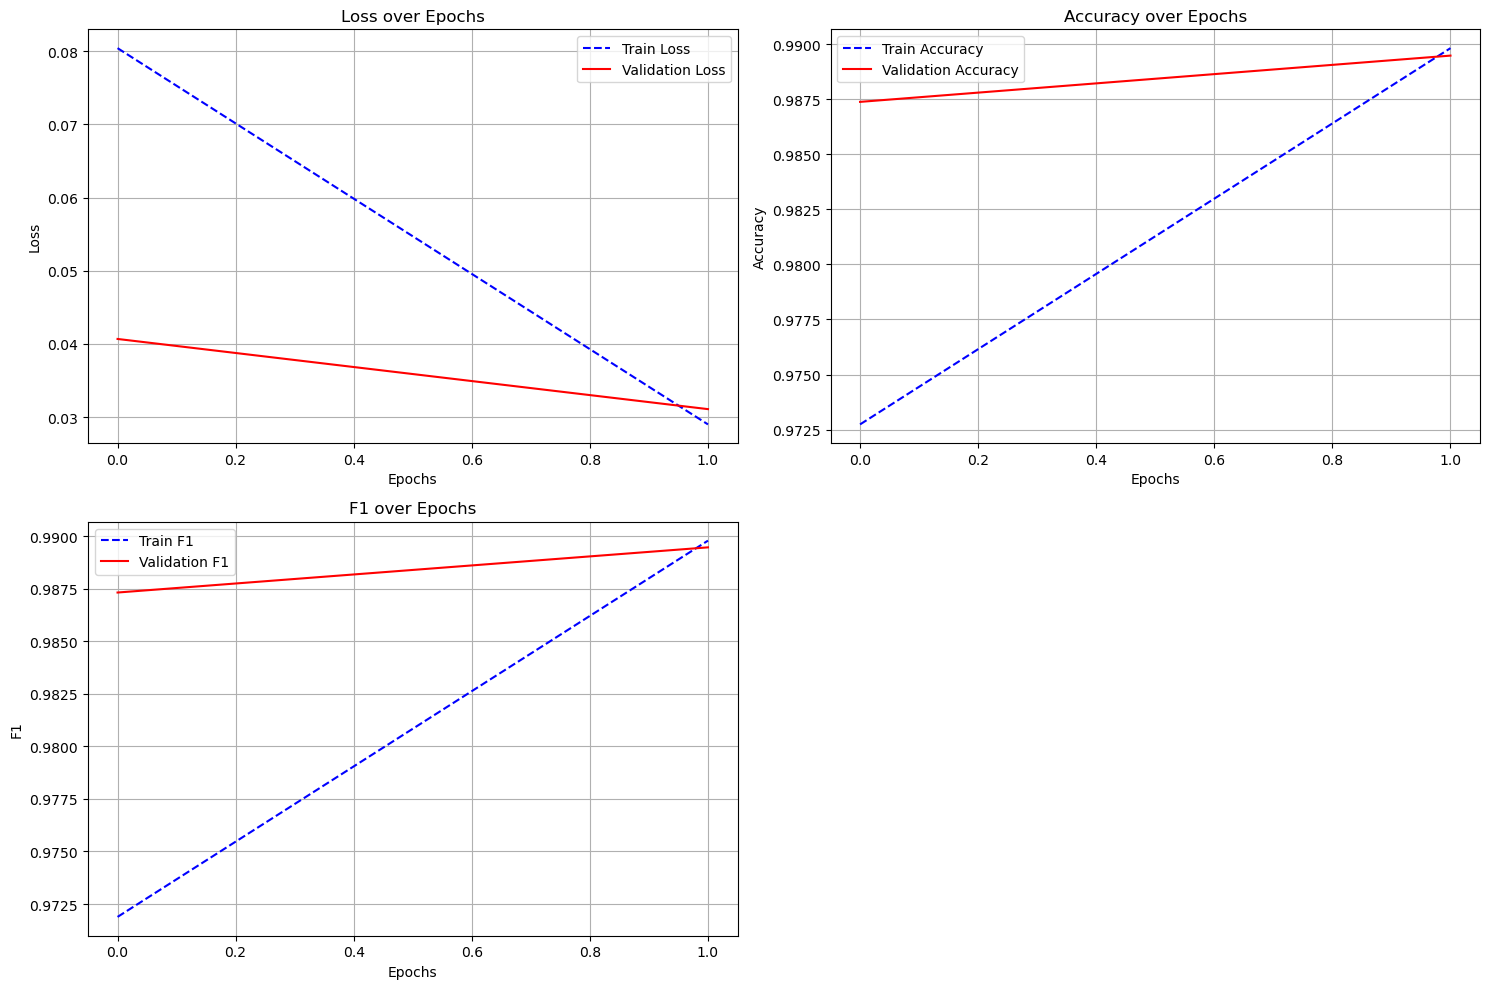

In [71]:
trainer.plot_results()

In [72]:
model_save_path = DATA_PATH_SAVE_MODELS / "covid_vaccine_fake_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Модель и токинайзер сохранены в: {model_save_path}")

Модель и токинайзер сохранены в: data\models\covid_vaccine_fake_model


## Энтропия (уверенность модели)

In [73]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score
from torch.utils.data import DataLoader
from typing import Dict, Any


def compute_entropy_thresholds(model: torch.nn.Module, dataloader: DataLoader, device: torch.device) -> Dict[str, Any]:
    """
    Вычисляет энтропию предсказаний модели для каждой категории и находит оптимальные пороги.
    
    Args:
        model (torch.nn.Module): Обученная модель для классификации.
        dataloader (DataLoader): Валидационный датасет.
        device (torch.device): CUDA или CPU.

    Returns:
        Dict[str, Any]: Содержит оптимальные пороги энтропии, ROC AUC и DataFrame с результатами.
    """
    model.to(device)
    model.eval()

    # Словари для хранения энтропии и корректности предсказаний
    entropies_per_class = defaultdict(list)
    correct_per_class = defaultdict(list)

    # Сбор данных
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = F.softmax(outputs.logits, dim=1)

            # Энтропия предсказания
            entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-15), dim=1)
            predicted_labels = torch.argmax(probabilities, dim=1)
            correct = (predicted_labels == labels).float()

            # Сохраняем значения по классам
            for i in range(len(labels)):
                label = labels[i].item()
                entropies_per_class[label].append(entropy[i].item())
                correct_per_class[label].append(correct[i].item())

    # Определение оптимального порога энтропии
    optimal_thresholds = {}
    roc_aucs = {}
    all_entropies = []
    all_correct = []
    results = []

    plt.figure(figsize=(12, 8))

    for label, entropies in entropies_per_class.items():
        correct = np.array(correct_per_class[label])
        entropies = np.array(entropies)

        if len(np.unique(correct)) < 2:
            optimal_thresholds[label] = None
            roc_aucs[label] = None
            results.append({'label': label, 'AUC': None, 'optimal_threshold': None})
            continue

        # ROC и AUC
        fpr, tpr, thresholds = roc_curve(correct, -entropies)
        roc_auc = roc_auc_score(correct, -entropies)

        # Оптимальный порог
        youden_j = tpr - fpr
        optimal_idx = np.argmax(youden_j)
        optimal_threshold = -thresholds[optimal_idx]

        optimal_thresholds[label] = optimal_threshold
        roc_aucs[label] = roc_auc

        all_entropies.extend(entropies)
        all_correct.extend(correct)

        # Сохранение результатов
        results.append({'label': label, 'AUC': roc_auc, 'optimal_threshold': optimal_threshold})

        # Добавляем кривую на график
        plt.plot(fpr, tpr, label=f'Class {label} (AUC = {roc_auc:.4f})')
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red')

    # Общий порог энтропии
    all_entropies = np.array(all_entropies)
    all_correct = np.array(all_correct)
    fpr, tpr, thresholds = roc_curve(all_correct, -all_entropies)
    roc_auc = roc_auc_score(all_correct, -all_entropies)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    overall_optimal_threshold = -thresholds[optimal_idx]

    print(f"Общий оптимальный порог энтропии: {overall_optimal_threshold:.4f}")
    print(f"AUC ROC (общий): {roc_auc:.4f}")

    # Добавляем общую ROC-кривую
    plt.plot(fpr, tpr, label=f'Overall (AUC = {roc_auc:.4f})', linestyle='--', color='black')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='blue', label='Overall Optimal')

    # Настройки графика
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class and Overall')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Создание DataFrame с результатами
    results_df = pd.DataFrame(results)

    return {
        'overall_optimal_threshold': overall_optimal_threshold,
        'optimal_thresholds': optimal_thresholds,
        'roc_aucs': roc_aucs,
        'results_df': results_df
    }


Общий оптимальный порог энтропии: 0.0656
AUC ROC (общий): 0.9784


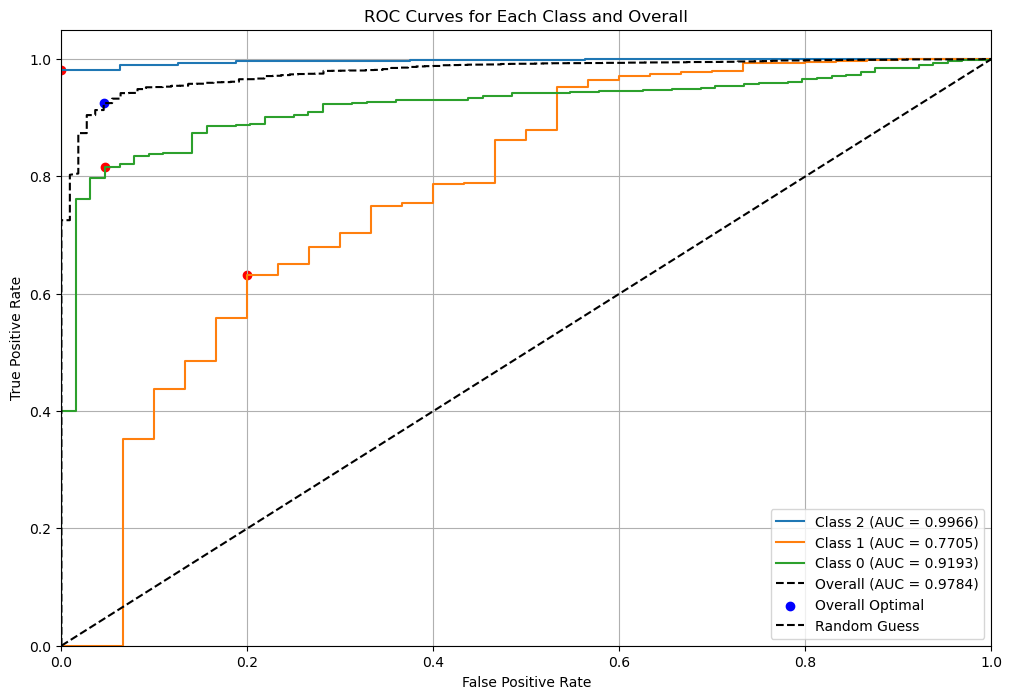

   label       AUC  optimal_threshold
0      2  0.996633           0.048492
1      1  0.770476           0.119393
2      0  0.919256           0.122038


In [74]:
entropy_dict = compute_entropy_thresholds(model, val_loader, DEVICE)

print(entropy_dict["results_df"])


In [75]:
entropy_dict["optimal_thresholds"]

{2: 0.048492107540369034, 1: 0.1193934753537178, 0: 0.12203813344240189}

# Тестирование

In [87]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F
from typing import Dict


def test_model(
    model: torch.nn.Module,
    test_loader: DataLoader,
    test_df: pd.DataFrame,
    idx2label: Dict[int, str],
    entropy_thresholds: Dict[int, float],  # Пороги энтропии по категориям
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
) -> pd.DataFrame:
    """
    Тестирует модель на тестовом DataLoader и возвращает DataFrame с результатами.

    Args:
        model (torch.nn.Module): Обученная модель.
        test_loader (DataLoader): DataLoader для тестового набора.
        test_df (pd.DataFrame): Исходный DataFrame тестовых данных.
        idx2label (dict): Словарь, отображающий индексы категорий в названия.
        entropy_thresholds (dict): Оптимальные пороги энтропии по категориям.
        device (torch.device): Устройство для вычислений (CPU/GPU).

    Returns:
        pd.DataFrame: DataFrame с результатами, содержащий:
            - 'text': текст примера,
            - 'true_label': истинная метка,
            - 'predicted_label': предсказанная метка,
            - 'probability': вероятность предсказания,
            - 'correct': корректность предсказания (True/False),
            - 'entropy': энтропия предсказания,
            - 'entropy_threshold': порог энтропии для категории,
            - 'passed_threshold': прошло ли предсказание порог энтропии.
    """
    model.eval()
    model.to(device)

    test_results = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            true_labels = batch["labels"].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probabilities = torch.softmax(logits, dim=-1)

            # Энтропия предсказания
            entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-15), dim=1)

            predictions = torch.argmax(probabilities, dim=-1).cpu().numpy()
            true_labels = true_labels.cpu().numpy()
            entropies = entropy.cpu().numpy()
            probabilities = probabilities.cpu().numpy()

            for true_label, predicted_label, probs, entropy_value in zip(true_labels, predictions, probabilities, entropies):
                entropy_threshold = entropy_thresholds.get(predicted_label, None)
                passed_threshold = entropy_value < entropy_threshold if entropy_threshold is not None else None

                test_results.append({
                    "true_label": idx2label[true_label],
                    "predicted_label": idx2label[predicted_label],
                    "probability": probs.tolist(),
                    "correct": true_label == predicted_label,
                    "entropy": entropy_value,
                    "entropy_threshold": entropy_threshold,
                    "passed_threshold": passed_threshold,
                })

    test_results_df = pd.DataFrame(test_results)

    test_df = test_df.reset_index(drop=True)
    test_df = pd.concat([test_df, test_results_df], axis=1)

    accuracy = accuracy_score(test_df["true_label"], test_df["predicted_label"])
    f1 = f1_score(test_df["true_label"], test_df["predicted_label"], average="weighted")

    print("\n=== Результаты тестирования ===")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")

    return test_df


In [88]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained(DATA_PATH_SAVE_MODELS / "covid_vaccine_fake_model")
model = RobertaForSequenceClassification.from_pretrained(
    DATA_PATH_SAVE_MODELS / "covid_vaccine_fake_model")

model.to(DEVICE)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [89]:
test_results_df = test_model(
    model=model,
    test_loader=test_loader,
    test_df=test_df,
    idx2label=idx2label,
    entropy_thresholds=entropy_dict["optimal_thresholds"],
    device=DEVICE,
)

Testing:   0%|          | 0/91 [00:00<?, ?it/s]


=== Результаты тестирования ===
Accuracy: 98.91%
F1 Score: 0.9891


In [90]:
test_results_df.sample(10)

,text,label_idx,original_label_1,source,original_label_2,label_str,true_label,predicted_label,probability,correct,entropy,entropy_threshold,passed_threshold
10911,"I did it was really really hot and sunny, and am sad am back",2,False,twitter,,Comments,Comments,Comments,"[0.00010105571709573269, 7.806330540915951e-05, 0.99982088804245]",True,0.002665,0.048492,True
5402,"So that's the trick Really enjoy your posts, btw, remarkably varied and insightful!",2,True,twitter,,Comments,Comments,Comments,"[0.00012282172974664718, 9.709874575491995e-05, 0.999779999256134]",True,0.003207,0.048492,True
4791,Danny and then Tom closely followed yours Danny? lol. x,2,True,twitter,,Comments,Comments,Comments,"[0.00010315349936718121, 6.43838502583094e-05, 0.9998325109481812]",True,0.002504,0.048492,True
11139,"Oh yea, join the club I'm feeling wasted myself!! Luv it!!",2,True,twitter,,Comments,Comments,Comments,"[7.1592592576053e-05, 6.320236570900306e-05, 0.9998651742935181]",True,0.002062,0.048492,True
2959,aww my little darling,2,False,twitter,,Comments,Comments,Comments,"[7.410299440380186e-05, 5.470388714456931e-05, 0.9998711347579956]",True,0.001977,0.048492,True
2268,"hopefully. Least my party of choice isn't in bed with homophobes, dear.",2,True,twitter,,Comments,Comments,Comments,"[0.0002791146980598569, 0.00027691334253177047, 0.9994439482688904]",True,0.007370,0.048492,True
9046,dictatorial threats mean nothing ive violated policy banned wiki privilege site going obsolete like run biased heap website ability fair might saved seem likely,2,False,toxic_comments,,Comments,Comments,Comments,"[0.00010721065336838365, 9.524106280878186e-05, 0.999797523021698]",True,0.002978,0.048492,True
4047,thanks already saw knew coming hasspoken,2,True,toxic_comments,,Comments,Comments,Comments,"[8.7467284174636e-05, 6.210686842678115e-05, 0.9998503923416138]",True,0.002263,0.048492,True
8606,lmao i am soo proud of my eye makeup..i almost cried XD,2,True,twitter,,Comments,Comments,Comments,"[8.02158028818667e-05, 7.81325506977737e-05, 0.999841570854187]",True,0.002386,0.048492,True
9058,we're both good how's you &amp; the gorgeous little Hunter?,2,True,twitter,,Comments,Comments,Comments,"[8.237719157477841e-05, 7.073820597724989e-05, 0.9998469352722168]",True,0.002314,0.048492,True


In [100]:
import pandas as pd

pd.options.display.max_colwidth = 300


test_results_df.loc[
    (test_results_df["predicted_label"] == "Fake")
].sample(10)

,text,label_idx,original_label_1,source,original_label_2,label_str,true_label,predicted_label,probability,correct,entropy,entropy_threshold,passed_threshold
5565,COVID-19 vaccine poses risk when taken before and after periods,1,False,justinqbui_1,,Fake,Fake,Fake,"[0.012371129356324673, 0.9874262809753418, 0.00020262060570530593]",True,0.098906,0.119393,True
8584,Cruise lines now offer deluxe coronavirus upgrade over basic norovirus package,1,fake,nanyy1025,,Fake,Fake,Fake,"[0.017445122823119164, 0.9823431372642517, 0.00021174702851567417]",True,0.129729,0.119393,False
11112,the video shows the bodies of deceased COVID-19 victims washing ashore after some countries disposed of them in the sea,1,False,justinqbui_1,,Fake,Fake,Fake,"[0.002578569808974862, 0.9970406889915466, 0.00038066162960603833]",True,0.030761,0.119393,True
11002,"CNN anchor decries controversial police unit, Covid-19 deaths in Nigeria",1,False,justinqbui_1,,Fake,Fake,Fake,"[0.004942461382597685, 0.994819700717926, 0.0002379210345679894]",True,0.048180,0.119393,True
8827,RETRACTED: Hydroxychloroquine or chloroquine with or without a macrolide for treatment of COVID-19: a multinational registry analysis - The Lancet,1,fake,nanyy1025,,Fake,Fake,Fake,"[0.2079472839832306, 0.791716456413269, 0.00033629449899308383]",True,0.741793,0.119393,False
8573,Covaxin COVID-19 vaccine contains new born calf serum.,1,False,justinqbui_1,,Fake,Fake,Fake,"[0.02407960221171379, 0.9756046533584595, 0.00031566989491693676]",True,0.167886,0.119393,False
2267,The World Health Organization “now admits that asymptomatic transmission of COVID-19 is very rare.”,0,half-true,justinqbui_2,misleading,Real,Real,Fake,"[0.23730581998825073, 0.7622362375259399, 0.0004579645174089819]",False,0.796093,0.119393,False
11490,The Pfizer COVID-19 vaccine “is not approved.”,1,false,justinqbui_2,false,Fake,Fake,Fake,"[0.09700577706098557, 0.9018580913543701, 0.001136064063757658]",True,0.472015,0.119393,False
4740,"“Hundreds of thousands died after taking the advice of these celebrities,” who are “aiding and abetting mass murder” by advocating COVID-19 vaccination.",1,False,justinqbui_1,,Fake,Fake,Fake,"[0.14997027814388275, 0.8493533730506897, 0.0006763141718693078]",True,0.617704,0.119393,False
3635,Vaccines do not contain microchips or tracking devices. Such claims are misinformation and have been debunked by experts.,0,,synthetic,,Real,Real,Fake,"[0.0053765857592225075, 0.9940294027328491, 0.0005940102273598313]",False,0.055489,0.119393,True


In [99]:
import pandas as pd

pd.options.display.max_colwidth = 300


test_results_df.loc[
    (test_results_df["predicted_label"] == "Real")
].sample(10)

,text,label_idx,original_label_1,source,original_label_2,label_str,true_label,predicted_label,probability,correct,entropy,entropy_threshold,passed_threshold
471,After running near 20% for most of April the cumulative positive rate has fallen a couple percent. All of these things are good signs even if we did add more than 27k positive cases to the rolls.,0,real,nanyy1025,,Real,Real,Real,"[0.9972898960113525, 0.0022942693904042244, 0.0004158267693128437]",True,0.028691,0.122038,True
107,Our daily update is published. We’ve tracked a total of 1407271 completed tests up from 1267658 yesterday. That's a big jump the biggest yet: 140k. Note: we can only track what a state reports and not all states report all tests. For details:,0,real,nanyy1025,,Real,Real,Real,"[0.9979092478752136, 0.0016680139815434813, 0.0004226604360155761]",True,0.023142,0.122038,True
6456,Correctional facilities present unique challenges to slowing spread of As of April 28 a total of 420 correctional facilities reported 4893 COVID-19 cases among detained or incarcerated people &amp; 2778 cases among facility staff. More,0,real,nanyy1025,,Real,Real,Real,"[0.9976713061332703, 0.0019806474447250366, 0.00034795323153957725]",True,0.025139,0.122038,True
8071,BREAKING: Sky News understands further lockdown restrictions are set to be imposed in the North East of England. Sky's has the latest 👇 Read more:,0,real,nanyy1025,,Real,Real,Real,"[0.9959499835968018, 0.0035933032631874084, 0.00045668866368941963]",True,0.040078,0.122038,True
3862,Our daily update is published. States reported 769k tests 64k new cases and 523 deaths. Hospitalizations fell a little but there’s a major caveat there: The decline is due to strange data from Alabama.,0,real,nanyy1025,,Real,Real,Real,"[0.9970105886459351, 0.0025972758885473013, 0.00039212999399751425]",True,0.031051,0.122038,True
7048,Test patients’ vitamin D levels to improve immunoresponse to,0,real,nanyy1025,,Real,Real,Real,"[0.6967191100120544, 0.30288437008857727, 0.0003965148644056171]",True,0.889634,0.122038,False
10296,Black children with COVID-19 at higher risk of developing the Kawasaki-like inflammatory condition MIS-C.,0,real,nanyy1025,,Real,Real,Real,"[0.5955957174301147, 0.40399396419525146, 0.0004103610117454082]",True,0.978141,0.122038,False
5136,"Vaccines stimulate the production of memory cells in the immune system. These cells ""remember"" how to fight a specific pathogen.",0,,synthetic,,Real,Real,Real,"[0.9617785215377808, 0.03773590922355652, 0.0004855259321630001]",True,0.237831,0.122038,False
7244,COVID-19 vaccination programs include measures to monitor and report adverse events. This ensures rapid responses to any potential safety concerns.,0,,synthetic,,Real,Real,Real,"[0.9934753775596619, 0.0062710875645279884, 0.0002535026869736612]",True,0.058297,0.122038,True
10,Pfizer’s announces that it will most likely know if their vaccine is effective by the end of October. If so Pfizer plans to begin distribution by 2021. The company is now looking to add more diverse and vulnerable populations to their trial.,0,real,nanyy1025,,Real,Real,Real,"[0.9415281414985657, 0.058266781270504, 0.00020502688130363822]",True,0.323316,0.122038,False


In [91]:
test_results_df.to_excel(DATA_PATH / 'test_results_learning.xlsx', index=False)

In [92]:
from transformers import PreTrainedTokenizer, PreTrainedModel
import torch


def test_model_with_text(
    model: PreTrainedModel,
    tokenizer: PreTrainedTokenizer,
    text: str,
    max_length: int = 128,
    label_map: dict = None,
):
    """
    Проверяет модель на введенном вручную тексте, используя argmax для классификации.

    Args:
        model (PreTrainedModel): Загруженная обученная модель (например, RobertaForSequenceClassification).
        tokenizer (PreTrainedTokenizer): Токенизатор для подготовки текста.
        text (str): Текст для классификации.
        max_length (int): Максимальная длина токенизированного текста.
        label_map (dict): Словарь для отображения меток, если метки числовые.

    Returns:
        dict: Словарь с текстом, вероятностями и предсказанными метками.
    """

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        text,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]  # Вероятности для каждого класса

    predicted_index = torch.argmax(logits, dim=-1).item()
    predicted_label = label_map[predicted_index] if label_map else predicted_index

    # Результаты
    result = {
        "text": text,
        "probabilities": probs.tolist(),
        "predicted_label": predicted_label
    }

    return result


Real

In [93]:
text = "COVID-19 vaccines do not affect fertility or reproductive health. This has been confirmed through multiple studies and ongoing research."

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'COVID-19 vaccines do not affect fertility or reproductive health. This has been confirmed through multiple studies and ongoing research.', 'probabilities': [0.7534753084182739, 0.24608100950717926, 0.0004436891176737845], 'predicted_label': 'Real'}


Fake

In [94]:
text = "COVID-19 vaccines affect fertility or reproductive health."

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'COVID-19 vaccines affect fertility or reproductive health.', 'probabilities': [0.21363011002540588, 0.7860375046730042, 0.00033243189682252705], 'predicted_label': 'Fake'}


In [95]:
text = "Arginine gave me a powerful boost of energy, I can really feel how it pumped me up. In the gym, it’s way easier to handle the weights, and my endurance is through the roof. It feels like my muscles are growing before my eyes, and the post-workout feeling is just awesome. I’m enjoying every moment as I feel my body reacting to the load. It’s definitely a great motivation to keep pushing forward! covid ruined everything though"

result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

text = '''
The new strain of the Omicron coronavirus was first detected in South Africa and Botswana in November 2021. It is rapidly spreading all over the world. The omicron strain contains more than 30 mutations in the S-protein spike on the virus shell, with which it enters the cell.
'''
result = test_model_with_text(
    model=model,
    tokenizer=tokenizer,
    text=text,
    max_length=128,
    label_map=idx2label
)

print(result)

{'text': 'Arginine gave me a powerful boost of energy, I can really feel how it pumped me up. In the gym, it’s way easier to handle the weights, and my endurance is through the roof. It feels like my muscles are growing before my eyes, and the post-workout feeling is just awesome. I’m enjoying every moment as I feel my body reacting to the load. It’s definitely a great motivation to keep pushing forward! covid ruined everything though', 'probabilities': [0.03248745575547218, 0.1955326795578003, 0.7719798684120178], 'predicted_label': 'Comments'}
{'text': '\nThe new strain of the Omicron coronavirus was first detected in South Africa and Botswana in November 2021. It is rapidly spreading all over the world. The omicron strain contains more than 30 mutations in the S-protein spike on the virus shell, with which it enters the cell.\n', 'probabilities': [0.09138131886720657, 0.9084268808364868, 0.00019180566596332937], 'predicted_label': 'Fake'}
